# Model Notebook for Voice Gender Detector

In [1]:
## Import Libraries

import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,Adamax,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models

import scipy
from scipy import stats
from scipy.stats import norm

from pathlib import Path
import os.path

import itertools

C:\Users\Abhinay\AppData\Local\Temp\ipykernel_21100\2273758155.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## Specify the file and read the Data

file_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train.csv"

# Reading the CSV file into a DataFrame
dftrain = pd.read_csv(file_path)
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB


In [3]:
dftrain

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN
195772,cv-valid-train/sample-195772.mp3,the irish man sipped his tea,1,0,NaN,NaN,NaN,NaN
195773,cv-valid-train/sample-195773.mp3,what do you know about that,1,0,NaN,NaN,NaN,NaN
195774,cv-valid-train/sample-195774.mp3,the phone rang while she was awake,2,0,twenties,male,us,NaN


In [4]:
## Displaying first 10 rows of the Dataset

dftrain.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
6,cv-valid-train/sample-000006.mp3,night fell and an assortment of fighting men a...,3,0,NaN,NaN,NaN,NaN
7,cv-valid-train/sample-000007.mp3,i heard a faint movement under my feet,2,1,NaN,NaN,NaN,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
9,cv-valid-train/sample-000009.mp3,when he speaks in our language i can interpret...,1,0,NaN,NaN,NaN,NaN


##### Visualization of Existing data in the dataset
##### We notice that the characteristics of voice have been explored and divided in terms of Gender,Age and Accent

In [5]:
## Array of Ages Classified

dftrain.age.unique()

array([nan, 'twenties', 'seventies', 'thirties', 'sixties', 'fifties',
       'fourties', 'teens', 'eighties'], dtype=object)

In [6]:
## Array of Genders Classified

dftrain.gender.unique()

array([nan, 'female', 'male', 'other'], dtype=object)

In [7]:
dftrain.accent.unique()

array([nan, 'us', 'england', 'australia', 'indian', 'canada', 'malaysia',
       'ireland', 'bermuda', 'scotland', 'african', 'newzealand', 'wales',
       'philippines', 'singapore', 'hongkong', 'southatlandtic'],
      dtype=object)

###### **BARPLOT OF ACCENT DIVIDED BY COUNTRIES**

<Axes: xlabel='accent'>

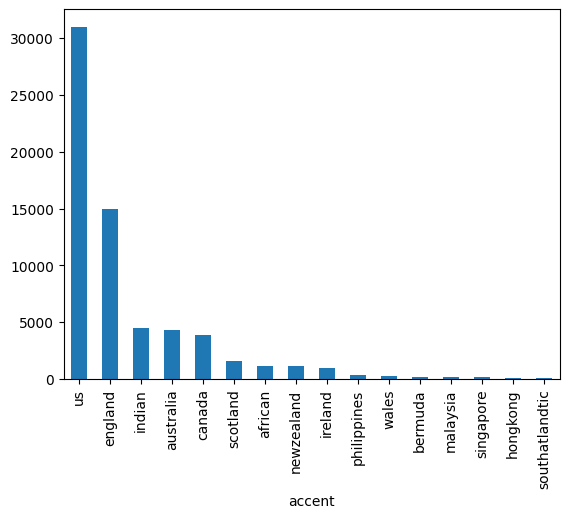

In [8]:
dftrain.accent.value_counts().plot.bar()

###### **BARPLOT OF AGES CLASSIFICATION**

<Axes: xlabel='age'>

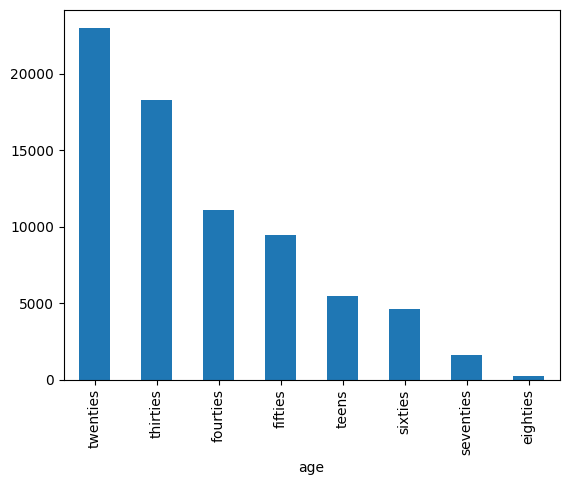

In [9]:
dftrain.age.value_counts().plot.bar()

###### **BARPLOT OF GENDER CLASSIFICATION**

<Axes: xlabel='gender'>

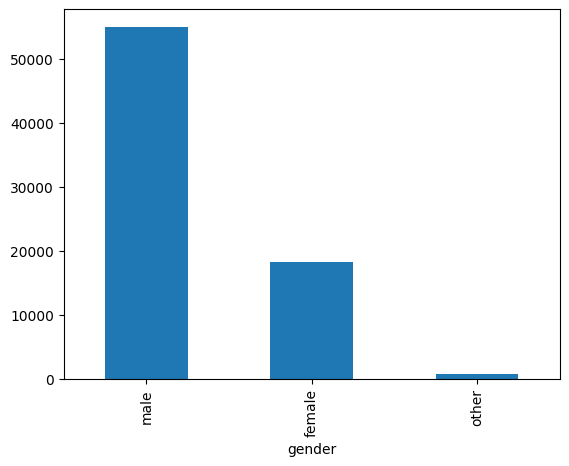

In [10]:
dftrain.gender.value_counts().plot.bar()

In [11]:
## Total no.of Audio Files
from IPython.display import display, Audio
import os
from pydub import AudioSegment
import subprocess

dataset_path = "C://Users//Abhinay//OneDrive//Desktop//Voice_Gender_Detector//cv-valid-train//cv-valid-train"

# Get the list of all files in the folder and sort them
all_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.mp3')])

# Get the total no.of files
total_files = len(all_files)
print(f'Total number of Audio files in the folder: {total_files}')

c:\Users\Abhinay\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Total number of Audio files in the folder: 195776


In [12]:
##  Listen to 10 Audios from the Dataset 
'''from IPython.display import display, Audio
import os
from pydub import AudioSegment

# Function to play audio file
def play_audio(audio_path):
    display(Audio(filename=audio_path))

# Specify the folder path containing MP3 files
folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Get the list of all files in the folder and sort them
all_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp3')])

# Get the total file count
total_files = len(all_files)
print(f'Total number of MP3 files in the folder: {total_files}')

# Play the first two audio files
for i in range(min(10, len(all_files))):
    file_path = os.path.join(folder_path, all_files[i])
    audio = AudioSegment.from_mp3(file_path)
    
    print(f'Playing file: {all_files[i]}')
    play_audio(file_path)'''

"from IPython.display import display, Audio\nimport os\nfrom pydub import AudioSegment\n\n# Function to play audio file\ndef play_audio(audio_path):\n    display(Audio(filename=audio_path))\n\n# Specify the folder path containing MP3 files\nfolder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'\n\n# Get the list of all files in the folder and sort them\nall_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp3')])\n\n# Get the total file count\ntotal_files = len(all_files)\nprint(f'Total number of MP3 files in the folder: {total_files}')\n\n# Play the first two audio files\nfor i in range(min(10, len(all_files))):\n    file_path = os.path.join(folder_path, all_files[i])\n    audio = AudioSegment.from_mp3(file_path)\n    \n    print(f'Playing file: {all_files[i]}')\n    play_audio(file_path)"

In [13]:
'''import os
import speech_recognition as sr
from pydub import AudioSegment

# Set the path to the audio files
audio_folder = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Get a list of all audio files in the folder
audio_files = [file for file in os.listdir(audio_folder) if file.endswith('.mp3')]

# Sort the audio files
audio_files.sort()

# Take the first 10 audio files
selected_audio_files = audio_files[:10]

# Initialize the recognizer
recognizer = sr.Recognizer()

# Process each selected audio file
for audio_file in selected_audio_files:
    # Load the audio file
    audio_path = os.path.join(audio_folder, audio_file)
    audio = AudioSegment.from_mp3(audio_path)

    # Convert the audio to WAV format (required by SpeechRecognition)
    audio.export("temp.wav", format="wav")

    # Recognize speech using Google Web Speech API
    with sr.AudioFile("temp.wav") as source:
        audio_data = recognizer.record(source)
        try:
            # Perform speech recognition
            text = recognizer.recognize_google(audio_data)
            print(f"Audio File: {audio_file}\nTranscription: {text}\n")
        except sr.UnknownValueError:
            print(f"Audio File: {audio_file}\nTranscription not recognized\n")
        except sr.RequestError as e:
            print(f"Audio File: {audio_file}\nError with the speech recognition service; {e}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")'''

"from IPython.display import display, Audio\nimport os\nfrom pydub import AudioSegment\n\n# Function to play audio file\ndef play_audio(audio_path):\n    display(Audio(filename=audio_path))\n\n# Specify the folder path containing MP3 files\nfolder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'\n\n# Get the list of all files in the folder and sort them\nall_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp3')])\n\n# Get the total file count\ntotal_files = len(all_files)\nprint(f'Total number of MP3 files in the folder: {total_files}')\n\n# Play the first two audio files\nfor i in range(min(10, len(all_files))):\n    file_path = os.path.join(folder_path, all_files[i])\n    audio = AudioSegment.from_mp3(file_path)\n    \n    print(f'Playing file: {all_files[i]}')\n    play_audio(file_path)"

In [14]:
## Display first five audio files from the Dataset 
import IPython
IPython.display.display(IPython.display.Audio("C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000000.mp3"))
IPython.display.display(IPython.display.Audio("C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000001.mp3"))
IPython.display.display(IPython.display.Audio("C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000002.mp3"))
IPython.display.display(IPython.display.Audio("C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000003.mp3"))
IPython.display.display(IPython.display.Audio("C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000004.mp3"))

##### **_Data Cleaning_**  i.e removing Background noise and enhancing low volume by **silence_threshold and keep_silence**

In [15]:
'''import os
from pydub import AudioSegment, silence
from concurrent.futures import ThreadPoolExecutor
from pydub.playback import play

# Function to adjust volume and remove background noise
def process_audio(file_path, reference_audio):
    # Load original audio
    original_audio = AudioSegment.from_mp3(file_path)
    
    # Adjust volume
    adjusted_audio = original_audio.apply_gain(reference_audio.dBFS - original_audio.dBFS)
    
    # Remove background noise
    adjusted_audio = remove_background_noise(adjusted_audio)
    
    # Trim or pad to match the length of the original audio with an extra 2 seconds
    adjusted_audio = match_audio_length(original_audio, adjusted_audio, extra_padding=2000)
    
    return adjusted_audio

# Function to remove background noise
def remove_background_noise(audio, silence_threshold=-30, keep_silence=100):
    # Split audio on silence and filter out silent chunks
    chunks = silence.split_on_silence(audio, silence_thresh=silence_threshold, keep_silence=keep_silence)
    filtered_audio = AudioSegment.silent()
    for chunk in chunks:
        filtered_audio += chunk

    return filtered_audio

# Function to match the length of two audio segments
def match_audio_length(original_audio, adjusted_audio, extra_padding=0):
    # Calculate the target length with extra padding
    target_length = len(original_audio) + extra_padding

    # Trim or pad to match the target length
    if len(adjusted_audio) < target_length:
        adjusted_audio = adjusted_audio + AudioSegment.silent(duration=target_length - len(adjusted_audio))
    elif len(adjusted_audio) > target_length:
        adjusted_audio = adjusted_audio[:target_length]

    return adjusted_audio

# Specify the folder path containing MP3 files
folder_path = '/kaggle/input/common-voice/cv-valid-train/cv-valid-train'

# Specify the reference file for volume adjustment
reference_file = 'sample-000000.mp3'
reference_file_path = os.path.join(folder_path, reference_file)
reference_audio = AudioSegment.from_mp3(reference_file_path)

# Process only the first 10 audio files
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.mp3')]
audio_files.sort()
selected_audio_files = audio_files[:10]

# Counter for tracking the number of files being processed
files_processed_counter = 0

# Process audio files (adjust volume and remove background noise) using parallelization
with ThreadPoolExecutor() as executor:
    # List of futures representing the ongoing audio processing tasks
    futures_process = []

    for file_name in selected_audio_files:
        file_path = os.path.join(folder_path, file_name)

        # Process audio (adjust volume and remove background noise)
        futures_process.append(executor.submit(process_audio, file_path, reference_audio))
        files_processed_counter += 1
        print(f'\rProcessing audio: {files_processed_counter} files processed', end='', flush=True)

    # Wait for all audio processing tasks to complete and retrieve results
    processed_audios = [future.result() for future in futures_process]

# Print the names of the processed audio files
print("\nNames of processed audio files:")
for i, file_name in enumerate(selected_audio_files):
    print(f"{i + 1}. {file_name}")'''

'import os\nfrom pydub import AudioSegment, silence\nfrom concurrent.futures import ThreadPoolExecutor\nfrom pydub.playback import play\n\n# Function to adjust volume and remove background noise\ndef process_audio(file_path, reference_audio):\n    # Load original audio\n    original_audio = AudioSegment.from_mp3(file_path)\n    \n    # Adjust volume\n    adjusted_audio = original_audio.apply_gain(reference_audio.dBFS - original_audio.dBFS)\n    \n    # Remove background noise\n    adjusted_audio = remove_background_noise(adjusted_audio)\n    \n    # Trim or pad to match the length of the original audio with an extra 2 seconds\n    adjusted_audio = match_audio_length(original_audio, adjusted_audio, extra_padding=2000)\n    \n    return adjusted_audio\n\n# Function to remove background noise\ndef remove_background_noise(audio, silence_threshold=-30, keep_silence=100):\n    # Split audio on silence and filter out silent chunks\n    chunks = silence.split_on_silence(audio, silence_thresh=s

In [16]:
## Play the Enhanced Audios

'''from IPython.display import Audio, display

# Specify the folder path to save the processed audio files
output_folder = '/kaggle/working/'

# Save the processed audio files with the same names
for i, audio in enumerate(processed_audios):
    file_name, file_extension = os.path.splitext(selected_audio_files[i])
    output_file_path = os.path.join(output_folder, f'{file_name}.mp3')
    audio.export(output_file_path, format='mp3')

    print(f'Saved processed audio: {output_file_path}')

    # Play the processed audio
    print(f'Playing Adjusted Audio: {selected_audio_files[i]}')
    display(Audio(output_file_path))'''

"from IPython.display import Audio, display\n\n# Specify the folder path to save the processed audio files\noutput_folder = '/kaggle/working/'\n\n# Save the processed audio files with the same names\nfor i, audio in enumerate(processed_audios):\n    file_name, file_extension = os.path.splitext(selected_audio_files[i])\n    output_file_path = os.path.join(output_folder, f'{file_name}.mp3')\n    audio.export(output_file_path, format='mp3')\n\n    print(f'Saved processed audio: {output_file_path}')\n\n    # Play the processed audio\n    print(f'Playing Adjusted Audio: {selected_audio_files[i]}')\n    display(Audio(output_file_path))"

##### **Comparing** Actual text and Predicted test by **_WORD ERROR RATE (WER)_**

In [17]:
'''import os
import pandas as pd
import speech_recognition as sr
import Levenshtein as lev
from pydub import AudioSegment
from pydub.effects import normalize

# Set the path to the audio files
csv_path = '/kaggle/input/common-voice/cv-valid-train.csv'

# Read the CSV file
df = pd.read_csv(csv_path)

# Use the processed audio files generated in the previous code
#processed_audios = [AudioSegment.from_mp3(file) for file in os.listdir('/kaggle/working') if file.startswith('processed_audio')]

# Take the first 10 processed audio files
selected_processed_audios = processed_audios[:10]

# Initialize the recognizer
recognizer = sr.Recognizer()

for i, audio in enumerate(selected_processed_audios):
    # Apply volume adjustment
    audio = normalize(audio)

    # Export the processed audio to a temporary WAV file
    audio.export("temp.wav", format="wav")

    # Retrieve actual text from the CSV based on filename
    filename_from_text = f'sample-{i:06d}.mp3'
    actual_text = df[df['filename'].str.split('/').str[-1] == filename_from_text]['text'].values


    if len(actual_text) > 0:
        actual_text = actual_text[0]

        # Recognize speech using Google Web Speech API
        with sr.AudioFile("temp.wav") as source:
            audio_data = recognizer.record(source)
            try:
                # Perform speech recognition
                text = recognizer.recognize_google(audio_data)
                # Calculate WER score
                wer_score = lev.distance(text.split(), actual_text.split()) / len(actual_text.split())

                # Print results
                print(f"Filename: {filename_from_text}")
                print(f"Predicted Text: {text}")
                print(f"Actual Text: {actual_text}")
                print(f"WER Score: {wer_score}\n")
            except sr.UnknownValueError:
                print(f"Audio File: {filename_from_text}\nTranscription not recognized\n")
            except sr.RequestError as e:
                print(f"Audio File: {filename_from_text}\nError with the speech recognition service; {e}\n")
    else:
        print(f"Actual text not found in CSV file for {filename_from_text}\n")

# Clean up the temporary WAV file
os.remove("temp.wav")'''


'import os\nimport pandas as pd\nimport speech_recognition as sr\nimport Levenshtein as lev\nfrom pydub import AudioSegment\nfrom pydub.effects import normalize\n\n# Set the path to the audio files\ncsv_path = \'/kaggle/input/common-voice/cv-valid-train.csv\'\n\n# Read the CSV file\ndf = pd.read_csv(csv_path)\n\n# Use the processed audio files generated in the previous code\n#processed_audios = [AudioSegment.from_mp3(file) for file in os.listdir(\'/kaggle/working\') if file.startswith(\'processed_audio\')]\n\n# Take the first 10 processed audio files\nselected_processed_audios = processed_audios[:10]\n\n# Initialize the recognizer\nrecognizer = sr.Recognizer()\n\nfor i, audio in enumerate(selected_processed_audios):\n    # Apply volume adjustment\n    audio = normalize(audio)\n\n    # Export the processed audio to a temporary WAV file\n    audio.export("temp.wav", format="wav")\n\n    # Retrieve actual text from the CSV based on filename\n    filename_from_text = f\'sample-{i:06d}.mp3\

In [18]:
dftrain

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN
195772,cv-valid-train/sample-195772.mp3,the irish man sipped his tea,1,0,NaN,NaN,NaN,NaN
195773,cv-valid-train/sample-195773.mp3,what do you know about that,1,0,NaN,NaN,NaN,NaN
195774,cv-valid-train/sample-195774.mp3,the phone rang while she was awake,2,0,twenties,male,us,NaN


In [19]:
## Specify the file and read the Data

file_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train.csv"

# Reading the CSV file into a DataFrame
dftrain = pd.read_csv(file_path)
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB


In [20]:
## Dropping NULL VALUES in Gender
dftrain = dftrain.dropna(subset=['gender'])

dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74059 entries, 5 to 195774
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    74059 non-null  object 
 1   text        74059 non-null  object 
 2   up_votes    74059 non-null  int64  
 3   down_votes  74059 non-null  int64  
 4   age         73466 non-null  object 
 5   gender      74059 non-null  object 
 6   accent      63756 non-null  object 
 7   duration    0 non-null      float64
dtypes: float64(1), int64(2), object(5)
memory usage: 5.1+ MB


In [21]:
dftrain.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


##### **_Visualization_** of above 5 voices in done here in terms of **WAVE FORM , SPECTROGRAM AND MFCC PLOT**

In [22]:
'''import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_folder_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000000.mp3"

# Extract two female and two male filenames from dftrain
female_files = dftrain[dftrain['gender'] == 'female']['filename'].head(2)
male_files = dftrain[dftrain['gender'] == 'male']['filename'].head(2)

# Function to plot waveform, spectrogram, and MFCC
def plot_features(file_path, gender):
    audio, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(15, 8))

    # Plot Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform - {gender}')
    
    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.title(f'Spectrogram - {gender}')

    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title(f'MFCC - {gender}')

    plt.tight_layout()
    plt.show()

# Plot features for female files
for file in female_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Female')

# Plot features for male files
for file in male_files:
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting features for {file_path}")
    plot_features(file_path, 'Male')'''

'import os\nimport librosa\nimport librosa.display\nimport matplotlib.pyplot as plt\n\naudio_folder_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train\\sample-000000.mp3"\n\n# Extract two female and two male filenames from dftrain\nfemale_files = dftrain[dftrain[\'gender\'] == \'female\'][\'filename\'].head(2)\nmale_files = dftrain[dftrain[\'gender\'] == \'male\'][\'filename\'].head(2)\n\n# Function to plot waveform, spectrogram, and MFCC\ndef plot_features(file_path, gender):\n    audio, sr = librosa.load(file_path, sr=None)\n    plt.figure(figsize=(15, 8))\n\n    # Plot Waveform\n    plt.subplot(3, 1, 1)\n    librosa.display.waveshow(audio, sr=sr)\n    plt.title(f\'Waveform - {gender}\')\n    \n    # Plot Spectrogram\n    plt.subplot(3, 1, 2)\n    S = librosa.feature.melspectrogram(y=audio, sr=sr)\n    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis=\'mel\', x_axis=\'time\')\n    plt.title(f\'Spectrogram - {gender}

##### **_Analyzing Pitch Contour_** i.e observing pitch in terms of **Pitch range, Average pitch** etc to distinguish between Male and Female

Plotting pitch contour for C:\Users\Abhinay\OneDrive\Desktop\Voice_Gender_Detector\cv-valid-train\cv-valid-train\sample-000005.mp3
Plotting pitch contour for C:\Users\Abhinay\OneDrive\Desktop\Voice_Gender_Detector\cv-valid-train\cv-valid-train\sample-000013.mp3
Plotting pitch contour for C:\Users\Abhinay\OneDrive\Desktop\Voice_Gender_Detector\cv-valid-train\cv-valid-train\sample-000008.mp3
Plotting pitch contour for C:\Users\Abhinay\OneDrive\Desktop\Voice_Gender_Detector\cv-valid-train\cv-valid-train\sample-000014.mp3


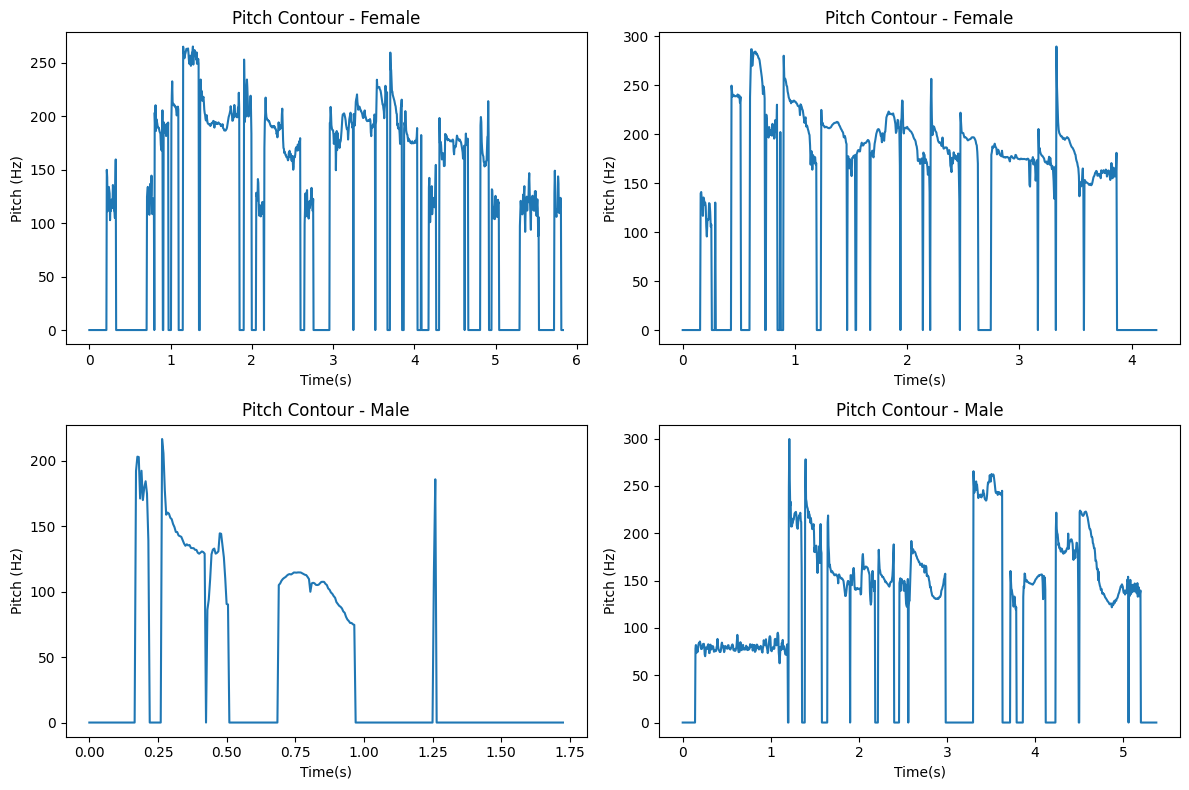

In [23]:
import os
import librosa
import pyworld as pw
import matplotlib.pyplot as plt

audio_folder_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train"

# Extract two female and two male filenames from dftrain
female_files = dftrain[dftrain['gender'] == 'female']['filename'].head(2)
male_files = dftrain[dftrain['gender'] == 'male']['filename'].head(2)

def plot_pitch_contour(file_path, gender, subplot_index):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Convert audio data to double
    audio = audio.astype('double')

    # Extract pitch using pyworld
    _f0, t = pw.dio(audio, sr)  # Dio algorithm
    f0 = pw.stonemask(audio, _f0, t, sr)

    # Plot pitch contour
    plt.subplot(2, 2, subplot_index)
    plt.plot(t, f0)
    plt.title(f'Pitch Contour - {gender}')
    plt.xlabel('Time(s)')
    plt.ylabel('Pitch (Hz)')

# Plot pitch contour for female files
plt.figure(figsize=(12, 8))
for i, file in enumerate(female_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Female', i)

# Plot pitch contour for male files
for i, file in enumerate(male_files, 1):
    file_path = os.path.join(audio_folder_path, file.split('/')[-1])
    print(f"Plotting pitch contour for {file_path}")
    plot_pitch_contour(file_path, 'Male', i + 2)  
plt.tight_layout()
plt.show()

##### **_Feature Extraction_** using 3 groups i.e **MFCC , CHROMA FEATURES, SPECTRAL CONTRAST MEASURES**

In [24]:
import os
import librosa
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Assuming dftrain is your DataFrame with 'filename' and 'gender' columns
# Replace this with the actual path to your audio files
audio_folder_path = "C:\\Users\\Abhinay\\OneDrive\\Desktop\\Voice_Gender_Detector\\cv-valid-train\\cv-valid-train"

def extract_audio_features(file_path, num_features=28):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio, n_mfcc=num_features)

        # Extract Chroma features
        chroma_features = librosa.feature.chroma_stft(y=audio, n_chroma=num_features)

        # Reduce either fmin or n_bands to address the Nyquist error
        contrast_features = librosa.feature.spectral_contrast(y=audio, n_bands=min(num_features, 6))

        # Concatenate all features
        all_features = np.concatenate((mfcc_features, chroma_features, contrast_features), axis=0)

        # Take the mean along the columns (axis=1)
        audio_features_mean = np.mean(all_features, axis=1)
        
        return audio_features_mean
    except Exception as e:
        print(f"Error processing file: {file_path}")
        print(e)
        return None


# Function to process a single row in dftrain
def process_row(row, feature_columns):
    file_name = row['filename'].split('/')[-1]
    file_path = os.path.join(audio_folder_path, file_name)

    if os.path.exists(file_path):
        audio_features_mean = extract_audio_features(file_path)
        
        if audio_features_mean is not None:
            # Add the mean audio features to the DataFrame
            for i, column in enumerate(feature_columns):
                dftrain.at[row.name, column] = audio_features_mean[i]
        else:
            # Handle the case where feature extraction failed
            print(f"Skipping file: {file_path}")

# Define the feature columns
audio_columns = [f'audio_feature_mean_{i}' for i in range(1, 29)]  # Adjusted to 28 audio features

# Add columns to store mean audio features
for column in audio_columns:
    dftrain[column] = None

# Extract mean audio features for the first 10,000 files in dftrain and add them as new columns using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_row, row, audio_columns) for _, row in dftrain.head(10000).iterrows()]

# Wait for all tasks to complete
for future in futures:
    future.result()

dftrain.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration,audio_feature_mean_1,audio_feature_mean_2,...,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_21,audio_feature_mean_22,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_26,audio_feature_mean_27,audio_feature_mean_28
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,-624.648437,112.143116,...,-5.971159,-8.026086,-7.050545,-2.395903,-0.461247,-6.477646,-9.04836,-3.291855,-0.834687,-3.752578
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN,-465.450028,129.926537,...,-5.994767,-7.321055,2.136044,-0.51982,-0.091372,3.036302,2.391196,3.747133,-1.438698,-5.469978
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,-418.681905,172.238835,...,-3.799932,-3.680291,-4.29386,-6.237994,-6.864157,-3.539646,-0.671063,-3.323203,-5.448705,-2.413586
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,-467.836003,110.097391,...,3.735575,-1.972156,-7.34892,-5.085369,1.642962,1.989853,-2.697836,-2.652054,0.340486,-0.831763
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,-349.42583,142.363606,...,-2.016612,7.757106,4.051686,-1.432403,-3.45612,2.198118,1.136141,3.889407,-1.568396,0.262695


In [25]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74059 entries, 5 to 195774
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   filename               74059 non-null  object 
 1   text                   74059 non-null  object 
 2   up_votes               74059 non-null  int64  
 3   down_votes             74059 non-null  int64  
 4   age                    73466 non-null  object 
 5   gender                 74059 non-null  object 
 6   accent                 63756 non-null  object 
 7   duration               0 non-null      float64
 8   audio_feature_mean_1   10000 non-null  object 
 9   audio_feature_mean_2   10000 non-null  object 
 10  audio_feature_mean_3   10000 non-null  object 
 11  audio_feature_mean_4   10000 non-null  object 
 12  audio_feature_mean_5   10000 non-null  object 
 13  audio_feature_mean_6   10000 non-null  object 
 14  audio_feature_mean_7   10000 non-null  object 
 15  audio_

In [26]:
dftrain

,filename,text,up_votes,down_votes,age,gender,accent,duration,audio_feature_mean_1,audio_feature_mean_2,...,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_21,audio_feature_mean_22,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_26,audio_feature_mean_27,audio_feature_mean_28
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,-624.648437,112.143116,...,-5.971159,-8.026086,-7.050545,-2.395903,-0.461247,-6.477646,-9.04836,-3.291855,-0.834687,-3.752578
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN,-465.450028,129.926537,...,-5.994767,-7.321055,2.136044,-0.51982,-0.091372,3.036302,2.391196,3.747133,-1.438698,-5.469978
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,-418.681905,172.238835,...,-3.799932,-3.680291,-4.29386,-6.237994,-6.864157,-3.539646,-0.671063,-3.323203,-5.448705,-2.413586
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,-467.836003,110.097391,...,3.735575,-1.972156,-7.34892,-5.085369,1.642962,1.989853,-2.697836,-2.652054,0.340486,-0.831763
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,-349.42583,142.363606,...,-2.016612,7.757106,4.051686,-1.432403,-3.45612,2.198118,1.136141,3.889407,-1.568396,0.262695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195766,cv-valid-train/sample-195766.mp3,but before i go i want to tell you a little story,1,0,fourties,male,england,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
195767,cv-valid-train/sample-195767.mp3,down below in the darkness were hundreds of pe...,3,0,thirties,female,us,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
195770,cv-valid-train/sample-195770.mp3,he heard a muffled grating sound and saw the b...,4,0,twenties,male,england,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
grouped_data = dftrain[dftrain['audio_feature_mean_1'].notnull()].groupby('gender').size()

grouped_data

gender
female    2494
male      7396
other      110
dtype: int64

In [28]:
## Selecting Non-NULL values

dftrain = dftrain[dftrain['audio_feature_mean_1'].notnull()]
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 5 to 26677
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   filename               10000 non-null  object 
 1   text                   10000 non-null  object 
 2   up_votes               10000 non-null  int64  
 3   down_votes             10000 non-null  int64  
 4   age                    9925 non-null   object 
 5   gender                 10000 non-null  object 
 6   accent                 8611 non-null   object 
 7   duration               0 non-null      float64
 8   audio_feature_mean_1   10000 non-null  object 
 9   audio_feature_mean_2   10000 non-null  object 
 10  audio_feature_mean_3   10000 non-null  object 
 11  audio_feature_mean_4   10000 non-null  object 
 12  audio_feature_mean_5   10000 non-null  object 
 13  audio_feature_mean_6   10000 non-null  object 
 14  audio_feature_mean_7   10000 non-null  object 
 15  audio_f

In [29]:
## Removing rows where Gender is other 

dftrain = dftrain[dftrain['gender'] != 'other']
gender_counts = dftrain['gender'].value_counts()
print(gender_counts)

gender
male      7396
female    2494
Name: count, dtype: int64


In [30]:
## Removing Unnecessary columns that are not required for training our Model

columns_to_remove = ['filename', 'text', 'up_votes', 'down_votes', 'age', 'accent', 'duration']
dftrain = dftrain.drop(columns=columns_to_remove, errors='ignore')


dftrain.head()

,gender,audio_feature_mean_1,audio_feature_mean_2,audio_feature_mean_3,audio_feature_mean_4,audio_feature_mean_5,audio_feature_mean_6,audio_feature_mean_7,audio_feature_mean_8,audio_feature_mean_9,...,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_21,audio_feature_mean_22,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_26,audio_feature_mean_27,audio_feature_mean_28
5,female,-624.648437,112.143116,4.192411,15.206,40.390527,18.015287,11.383596,19.198262,8.977469,...,-5.971159,-8.026086,-7.050545,-2.395903,-0.461247,-6.477646,-9.04836,-3.291855,-0.834687,-3.752578
8,male,-465.450028,129.926537,2.688087,12.046805,-7.246889,5.112121,6.854223,3.925433,13.581927,...,-5.994767,-7.321055,2.136044,-0.51982,-0.091372,3.036302,2.391196,3.747133,-1.438698,-5.469978
13,female,-418.681905,172.238835,-19.381154,-29.69637,23.51819,13.758429,3.875652,15.112429,4.395624,...,-3.799932,-3.680291,-4.29386,-6.237994,-6.864157,-3.539646,-0.671063,-3.323203,-5.448705,-2.413586
14,male,-467.836003,110.097391,21.651703,17.568868,28.396569,25.320973,18.938298,10.20823,3.628809,...,3.735575,-1.972156,-7.34892,-5.085369,1.642962,1.989853,-2.697836,-2.652054,0.340486,-0.831763
19,male,-349.42583,142.363606,7.281961,59.582689,-8.232778,22.511038,8.254271,8.506161,3.063953,...,-2.016612,7.757106,4.051686,-1.432403,-3.45612,2.198118,1.136141,3.889407,-1.568396,0.262695


In [31]:
## Label Encoding to see Gender column in Correlation Matrix

## Gender Encoded '0' for Female and '1' for Male
from sklearn.preprocessing import LabelEncoder

# Assuming 'gender' is the column to be encoded
label_encoder = LabelEncoder()
dftrain['gender_encoded'] = label_encoder.fit_transform(dftrain['gender'])
dftrain.head()

,gender,audio_feature_mean_1,audio_feature_mean_2,audio_feature_mean_3,audio_feature_mean_4,audio_feature_mean_5,audio_feature_mean_6,audio_feature_mean_7,audio_feature_mean_8,audio_feature_mean_9,...,audio_feature_mean_20,audio_feature_mean_21,audio_feature_mean_22,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_26,audio_feature_mean_27,audio_feature_mean_28,gender_encoded
5,female,-624.648437,112.143116,4.192411,15.206,40.390527,18.015287,11.383596,19.198262,8.977469,...,-8.026086,-7.050545,-2.395903,-0.461247,-6.477646,-9.04836,-3.291855,-0.834687,-3.752578,0
8,male,-465.450028,129.926537,2.688087,12.046805,-7.246889,5.112121,6.854223,3.925433,13.581927,...,-7.321055,2.136044,-0.51982,-0.091372,3.036302,2.391196,3.747133,-1.438698,-5.469978,1
13,female,-418.681905,172.238835,-19.381154,-29.69637,23.51819,13.758429,3.875652,15.112429,4.395624,...,-3.680291,-4.29386,-6.237994,-6.864157,-3.539646,-0.671063,-3.323203,-5.448705,-2.413586,0
14,male,-467.836003,110.097391,21.651703,17.568868,28.396569,25.320973,18.938298,10.20823,3.628809,...,-1.972156,-7.34892,-5.085369,1.642962,1.989853,-2.697836,-2.652054,0.340486,-0.831763,1
19,male,-349.42583,142.363606,7.281961,59.582689,-8.232778,22.511038,8.254271,8.506161,3.063953,...,7.757106,4.051686,-1.432403,-3.45612,2.198118,1.136141,3.889407,-1.568396,0.262695,1


In [32]:
## Converting all columns to float except Gender

dftrain[dftrain.columns.difference(['gender'])] = dftrain[dftrain.columns.difference(['gender'])].apply(pd.to_numeric, errors='coerce')

dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9890 entries, 5 to 26677
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 9890 non-null   object 
 1   audio_feature_mean_1   9890 non-null   float64
 2   audio_feature_mean_2   9890 non-null   float64
 3   audio_feature_mean_3   9890 non-null   float64
 4   audio_feature_mean_4   9890 non-null   float64
 5   audio_feature_mean_5   9890 non-null   float64
 6   audio_feature_mean_6   9890 non-null   float64
 7   audio_feature_mean_7   9890 non-null   float64
 8   audio_feature_mean_8   9890 non-null   float64
 9   audio_feature_mean_9   9890 non-null   float64
 10  audio_feature_mean_10  9890 non-null   float64
 11  audio_feature_mean_11  9890 non-null   float64
 12  audio_feature_mean_12  9890 non-null   float64
 13  audio_feature_mean_13  9890 non-null   float64
 14  audio_feature_mean_14  9890 non-null   float64
 15  audio_fe

#### **CORRELATION HEATMAP**

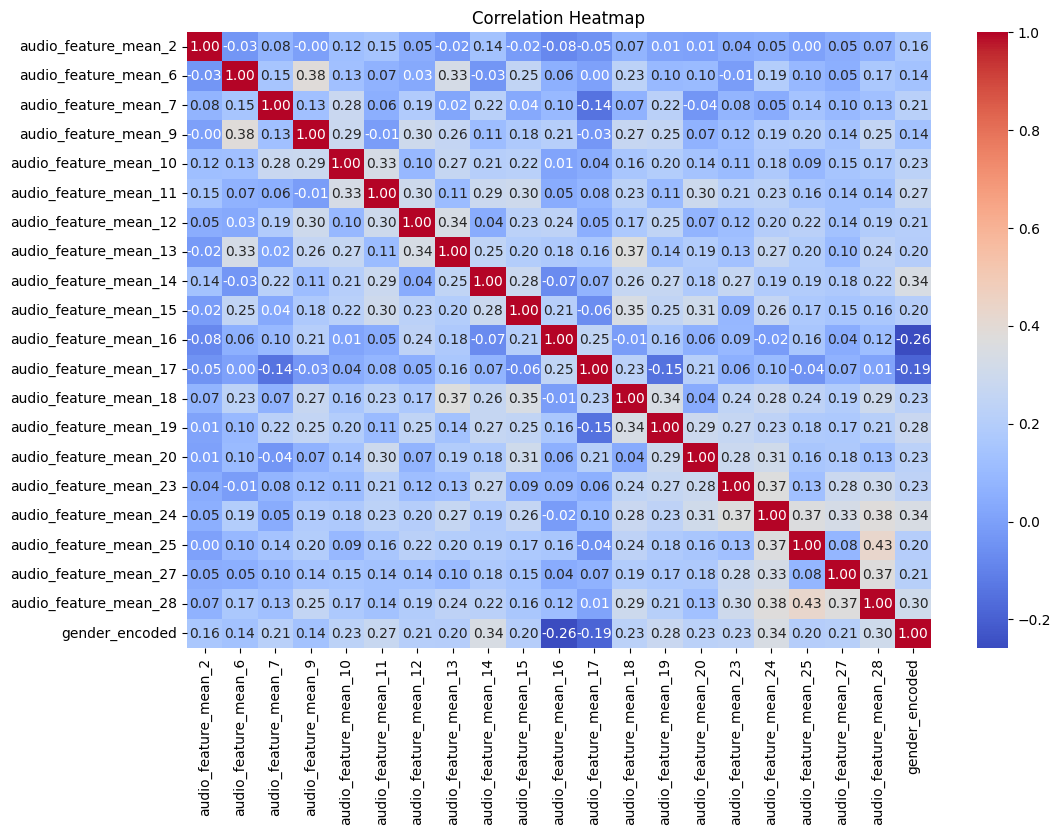

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude 'gender' column from correlation matrix for visualization
correlation_matrix = dftrain.drop(columns=['gender']).corr()

# Extract features with correlation less than 0.1 or greater than -0.1 with 'gender_encoded'
correlated_features = correlation_matrix[abs(correlation_matrix['gender_encoded']) < 0.1].index

# Drop the correlated features from the correlation matrix
correlation_matrix_filtered = correlation_matrix.drop(correlated_features, axis=1).drop(correlated_features, axis=0)

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [34]:
# Drop features with ABS value of correlation less than 0.1 with target 
dftrain_filtered = dftrain.drop(correlated_features, axis=1)

dftrain_filtered.head(10)

,gender,audio_feature_mean_2,audio_feature_mean_6,audio_feature_mean_7,audio_feature_mean_9,audio_feature_mean_10,audio_feature_mean_11,audio_feature_mean_12,audio_feature_mean_13,audio_feature_mean_14,...,audio_feature_mean_17,audio_feature_mean_18,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_27,audio_feature_mean_28,gender_encoded
5,female,112.143116,18.015287,11.383596,8.977469,0.388082,0.077003,-3.276914,-3.282056,-1.716983,...,2.402926,-0.899446,-5.971159,-8.026086,-0.461247,-6.477646,-9.048360,-0.834687,-3.752578,0
8,male,129.926537,5.112121,6.854223,13.581927,-3.678914,1.513631,3.810097,-5.460868,-5.027653,...,-10.228559,-4.011666,-5.994767,-7.321055,-0.091372,3.036302,2.391196,-1.438698,-5.469978,1
13,female,172.238835,13.758429,3.875652,4.395624,-8.858243,-6.087341,-6.997771,-8.206118,-2.190923,...,-6.969987,-4.291746,-3.799932,-3.680291,-6.864157,-3.539646,-0.671063,-5.448705,-2.413586,0
14,male,110.097391,25.320973,18.938298,3.628809,0.959613,0.649734,-3.542647,-6.408256,-1.218591,...,-9.934082,-0.541961,3.735575,-1.972156,1.642962,1.989853,-2.697836,0.340486,-0.831763,1
19,male,142.363606,22.511038,8.254271,3.063953,2.262861,11.316522,1.515863,9.225243,1.678960,...,4.501693,3.165058,-2.016612,7.757106,-3.456120,2.198118,1.136141,-1.568396,0.262695,1
20,male,114.235263,23.847534,5.825817,1.575814,-2.275695,12.457345,-4.037560,-2.629287,-3.591902,...,3.171573,0.347810,-5.624943,2.616831,-0.139167,0.970873,-5.028174,-0.462926,-0.824753,1
23,male,128.407875,2.143145,8.521441,-2.292377,12.387537,18.168859,-8.999442,-12.225155,7.725104,...,-11.965158,-4.248481,-0.380095,-0.494335,-1.314775,-1.785272,0.279177,-3.591661,-4.632011,1
26,female,122.273124,25.476834,11.241531,14.550264,1.533119,9.968439,-5.372754,-4.480352,-9.916530,...,-7.593154,-3.024708,-3.573244,3.188667,-3.894336,-0.170519,-0.161194,1.323972,-1.592522,0
27,male,139.011322,23.911585,17.694177,-2.203792,2.615657,1.308229,-7.332064,-6.225833,-1.707259,...,-3.895269,-8.072873,-6.411101,-2.080657,-2.620349,-1.671446,-1.655185,3.284394,1.371368,1
29,male,152.234566,18.425555,14.200418,4.462467,-1.559426,-4.035913,-8.810297,6.261013,0.579775,...,-4.710778,-0.770762,-5.706135,-8.429056,-3.429314,-4.289040,-5.937705,-1.452888,-1.583434,1


In [35]:
new_gender_counts= dftrain_filtered['gender'].value_counts()
print(new_gender_counts)

gender
male      7396
female    2494
Name: count, dtype: int64


In [36]:
## Deleting gender_encoded column because we need to add it after train and split to avoid data loss

dftrain_filtered = dftrain_filtered.drop(columns=['gender_encoded'])
dftrain_filtered.info()
dftrain_filtered

<class 'pandas.core.frame.DataFrame'>
Index: 9890 entries, 5 to 26677
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 9890 non-null   object 
 1   audio_feature_mean_2   9890 non-null   float64
 2   audio_feature_mean_6   9890 non-null   float64
 3   audio_feature_mean_7   9890 non-null   float64
 4   audio_feature_mean_9   9890 non-null   float64
 5   audio_feature_mean_10  9890 non-null   float64
 6   audio_feature_mean_11  9890 non-null   float64
 7   audio_feature_mean_12  9890 non-null   float64
 8   audio_feature_mean_13  9890 non-null   float64
 9   audio_feature_mean_14  9890 non-null   float64
 10  audio_feature_mean_15  9890 non-null   float64
 11  audio_feature_mean_16  9890 non-null   float64
 12  audio_feature_mean_17  9890 non-null   float64
 13  audio_feature_mean_18  9890 non-null   float64
 14  audio_feature_mean_19  9890 non-null   float64
 15  audio_fe

,gender,audio_feature_mean_2,audio_feature_mean_6,audio_feature_mean_7,audio_feature_mean_9,audio_feature_mean_10,audio_feature_mean_11,audio_feature_mean_12,audio_feature_mean_13,audio_feature_mean_14,...,audio_feature_mean_16,audio_feature_mean_17,audio_feature_mean_18,audio_feature_mean_19,audio_feature_mean_20,audio_feature_mean_23,audio_feature_mean_24,audio_feature_mean_25,audio_feature_mean_27,audio_feature_mean_28
5,female,112.143116,18.015287,11.383596,8.977469,0.388082,0.077003,-3.276914,-3.282056,-1.716983,...,-0.833024,2.402926,-0.899446,-5.971159,-8.026086,-0.461247,-6.477646,-9.048360,-0.834687,-3.752578
8,male,129.926537,5.112121,6.854223,13.581927,-3.678914,1.513631,3.810097,-5.460868,-5.027653,...,-9.354967,-10.228559,-4.011666,-5.994767,-7.321055,-0.091372,3.036302,2.391196,-1.438698,-5.469978
13,female,172.238835,13.758429,3.875652,4.395624,-8.858243,-6.087341,-6.997771,-8.206118,-2.190923,...,-7.422611,-6.969987,-4.291746,-3.799932,-3.680291,-6.864157,-3.539646,-0.671063,-5.448705,-2.413586
14,male,110.097391,25.320973,18.938298,3.628809,0.959613,0.649734,-3.542647,-6.408256,-1.218591,...,-7.694763,-9.934082,-0.541961,3.735575,-1.972156,1.642962,1.989853,-2.697836,0.340486,-0.831763
19,male,142.363606,22.511038,8.254271,3.063953,2.262861,11.316522,1.515863,9.225243,1.678960,...,-1.615864,4.501693,3.165058,-2.016612,7.757106,-3.456120,2.198118,1.136141,-1.568396,0.262695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26668,male,116.930917,9.144672,5.185719,14.556214,5.340289,-2.242834,-5.704836,-1.371425,2.574767,...,-6.340539,-2.970719,-1.274394,-2.869032,-3.838928,-0.165161,-2.363597,-4.593971,0.634093,-1.335509
26670,male,129.271561,22.360923,12.824431,25.089013,3.328144,10.897578,9.924939,0.885260,4.284354,...,1.352328,4.436539,5.826592,-0.798022,-5.840577,2.130343,0.501678,-1.095285,0.881765,-0.512807
26673,male,101.733113,20.453180,-0.192655,11.119372,-1.049780,5.359867,4.455333,1.120360,0.799971,...,-0.588505,2.461839,0.741503,-4.075694,1.947669,2.167927,-0.714152,0.875555,0.031779,-0.772515
26675,male,88.533131,3.255836,7.318224,13.465389,2.916947,0.825079,8.266844,4.247850,1.851354,...,0.867941,-0.409757,0.668039,-4.564067,-0.013641,1.394207,-0.761326,2.058682,-1.037130,-0.612154


### **Training and Evaluation**

We will be using **_Synthetic Minority Over Sampling Technique_ (SMOTE)** to get over bias between the two classes Male and Female

**SMOTE** will add more samples to lower class ensuring there will be less bias between both the classes

_This helps in balance class distribution for both majority and minority classes_

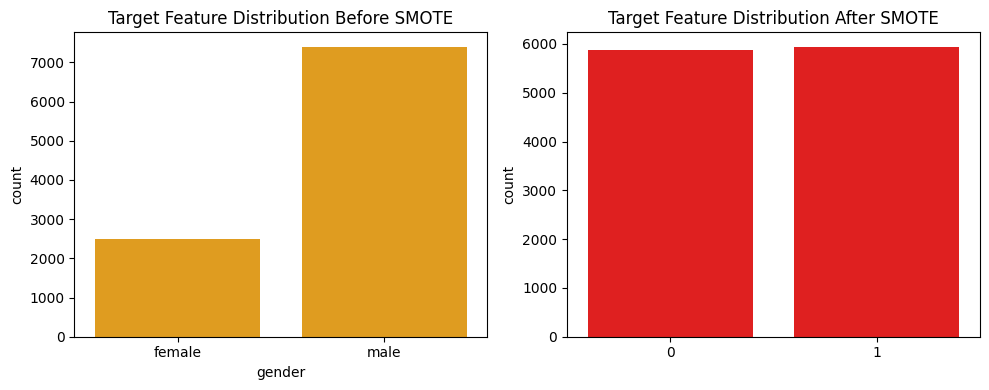

In [37]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

X = dftrain_filtered.drop(columns=['gender'])
y = dftrain_filtered['gender']

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 3: SMOTE for balancing classes
smote = SMOTE(sampling_strategy=0.99, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Step 4: Min-Max Scaling
scaler = MinMaxScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Plot the distribution of the target feature before SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=dftrain_filtered,color='orange')
plt.title('Target Feature Distribution Before SMOTE')

# Plot the distribution of the target feature after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled,color='red')
plt.title('Target Feature Distribution After SMOTE')

plt.tight_layout()
plt.show()

In [38]:
import tensorflow as tf

# Step 4: Build and Train TensorFlow Model with 5-fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Assuming X_train_resampled_scaled and y_train_resampled are NumPy arrays

# Convert back to DataFrames and drop the target column
X_train_resampled_scaled_df = pd.DataFrame(X_train_resampled_scaled, columns=dftrain_filtered.columns[1:])  # Exclude the first column
X_train_resampled_scaled_df.insert(0, dftrain_filtered.columns[0], dftrain_filtered[dftrain_filtered.columns[0]])  # Insert the first column at the beginning
X_train_resampled_scaled_df = X_train_resampled_scaled_df.drop(columns=['gender'])  # Drop the target column


y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['gender'])  # Assuming the target column name is 'gender'

In [39]:
# Mapping dictionary for class labels
class_label_mapping = {0: 'Female', 1: 'Male'} 

best_fold_results = None
best_fold = None

# Loop through folds
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_resampled_scaled_df, y_train_resampled_df), 1):
    X_train_fold, X_val_fold = X_train_resampled_scaled_df.iloc[train_index], X_train_resampled_scaled_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled_df.iloc[train_index], y_train_resampled_df.iloc[val_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled_scaled_df.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Convert data types to float32
    X_train_fold = X_train_fold.astype('float32')
    X_val_fold = X_val_fold.astype('float32')
    y_train_fold = y_train_fold.astype('int')  
    y_val_fold = y_val_fold.astype('int')  
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training
    print(f"\nFold {fold_num}:")
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))
    test_predictions = (model.predict(X_test_scaled) > 0.5).astype(int)
    cm_test = confusion_matrix(y_test_encoded, test_predictions)
    report_test = classification_report(y_test_encoded, test_predictions, target_names=[class_label_mapping[i] for i in range(len(class_label_mapping))], output_dict=True)

    # Save results if it's the best fold so far
    if best_fold_results is None or report_test['accuracy'] > best_fold_results['accuracy']:
        best_fold_results = report_test
        best_fold = fold_num





Fold 1:
Epoch 1/10


296/296 [==============================] - 2s 3ms/step - loss: 0.6375 - accuracy: 0.6975 - val_loss: 0.5724 - val_accuracy: 0.8388
Epoch 2/10
296/296 [==============================] - 0s 2ms/step - loss: 0.5180 - accuracy: 0.8146 - val_loss: 0.4551 - val_accuracy: 0.8515
Epoch 3/10
296/296 [==============================] - 1s 2ms/step - loss: 0.4363 - accuracy: 0.8327 - val_loss: 0.3966 - val_accuracy: 0.8562
Epoch 4/10
296/296 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8357 - val_loss: 0.3767 - val_accuracy: 0.8414
Epoch 5/10
296/296 [==============================] - 1s 2ms/step - loss: 0.3862 - accuracy: 0.8377 - val_loss: 0.3594 - val_accuracy: 0.8638
Epoch 6/10
296/296 [==============================] - 1s 3ms/step - loss: 0.3755 - accuracy: 0.8397 - val_loss: 0.3525 - val_accuracy: 0.8579
Epoch 7/10
296/296 [==============================] - 1s 2ms/step - loss: 0.3679 - accuracy: 0.8443 - val_loss: 0.3463 - val_accuracy: 

In [40]:
## Finding the best fold and combination for better result 
print(f"\nBest Fold: {best_fold}")


Best Fold: 5


In [41]:
## Evaluating MODEL
model.evaluate(X_val_fold, y_val_fold)

74/74 [==============================] - 0s 947us/step - loss: 0.3644 - accuracy: 0.8435


[0.36444729566574097, 0.8434855937957764]

In [42]:
pred=model.predict(X_train_fold)

296/296 [==============================] - 0s 852us/step


In [43]:
pred[0]

array([0.6935958], dtype=float32)

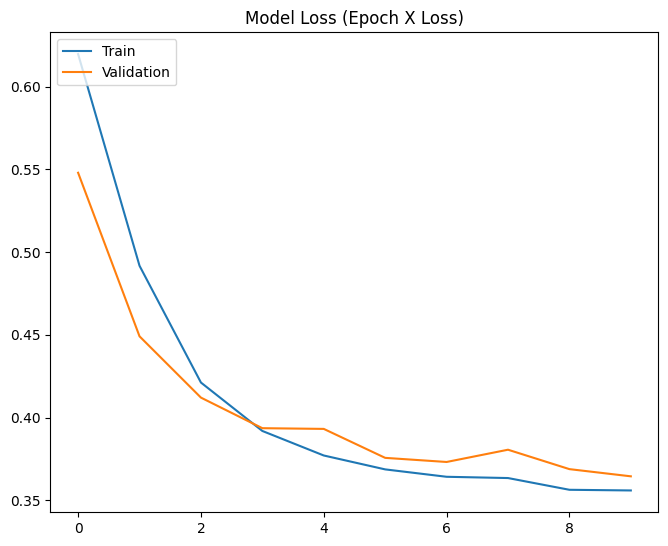

In [44]:
## Plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss (Epoch X Loss)")
plt.xlabel=('Epoch')
plt.ylabel=('Loss')
plt.legend(["Train",'Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

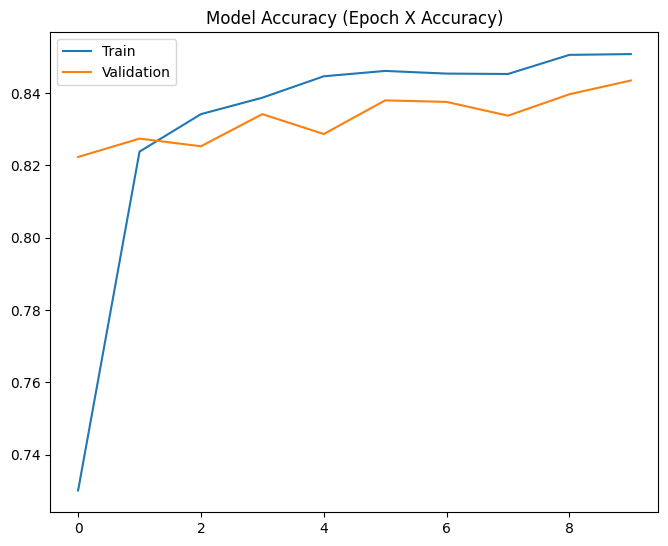

In [45]:
## Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy (Epoch X Accuracy)")

plt.xlabel=('Epoch')
plt.ylabel=('Accuracy')

plt.legend(['Train','Validation'])
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##### **CLASSIFICATION REPORT AND CONFUSION MATRIX**

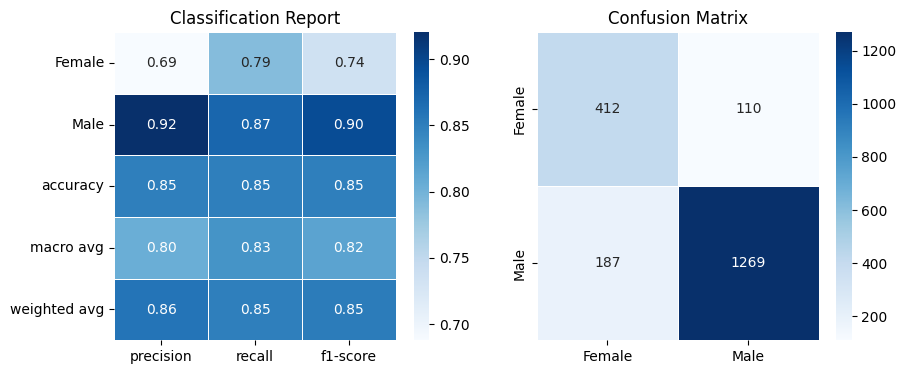

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Classification Report Heatmap
sns.heatmap(pd.DataFrame(best_fold_results).iloc[:-1, :].T, annot=True, cmap='Blues', fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Classification Report')

# Confusion Matrix Heatmap
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', linewidths=.5, xticklabels=[class_label_mapping[i] for i in range(len(class_label_mapping))], yticklabels=[class_label_mapping[i] for i in range(len(class_label_mapping))], ax=axes[1])
axes[1].set_title('Confusion Matrix')

plt.show()


In [48]:
import joblib
# save the model to disk
filename = 'Final_model.sav'
joblib.dump(model, filename)

['Final_model.sav']

In [53]:
test_pred=model.predict(X_val_fold)

74/74 [==============================] - 0s 985us/step


In [54]:
print(test_pred)

[[0.17998639]
 [0.07397233]
 [0.06710224]
 ...
 [0.20144486]
 [0.6117215 ]
 [0.06928581]]


NameError: name 'gender_encoded' is not defined